# 数据分析与实践实验五-实验报告

*刘眭怿 PB20061256 2023.6.1*

- [实验报告](#数据分析与实践实验五-实验报告)
  - [实验要求](#实验要求)
  - [实验分析](#实验分析)
  - [实验过程](#实验过程)
  - [实验总结](#实验总结)
  - [附录](#附录)

## 实验要求
> PISA2018包含了学生问卷，考试诊断，学校、老师等数个数据集。本次实验针对PICA2015中的学生调查问卷数据集，共490个特征。
> - 预测目标：`REPEAT`字段，学生是否复读(repeat grade);
> - 实现至少一种分类算法（例如：决策树、KNN、朴素贝叶斯或者感知机、集成算法等），可以使用现有的机器学习库；
> - 测试算法在 PISA2018数据集上的预测性能，以`ACC,F1-socre,AUC,ROC`等指标进行评价，进行交叉验证；
> - 记录最终的方案流程，需要包括主要流程、关键技术以及算法的性能，鼓励进行算法的改进；

## 实验分析

1. 选取特征集合进行预测，预处理过程参照实验三；
2. 实现一种分类算法，利用数据集进行训练，得到`模型一`；
3. 交叉验证，利用指标对模型进行评价；
4. 对数据进行清洗和筛选，例如简单区间的线性映射，肥尾效应的去除、正态分布的区间段划分等等；
5. 优化算法，再次进行模型的训练，得到`模型二`；
6. 对新模型进行交叉验证，利用指标对模型进行评价，并同`模型一`进行比较。

## 实验过程

### 特征选取

参照实验三的阶段性结论，我们选取如下的特征集合，具体数据统计量的考察见本人的实验三-实验报告\*：
```json
{
  "HISCED":"父母中最高受教育程度",
  "IMMIG":"家庭移民类型",
  "CHANGE":"受教育经历中转校次数总和",
  "ESCS":"经济、社会、文化综合指数",
  "BEINGBULLIED":"学生是否被欺凌(WLE)",
  "DISCRIM":"学校歧视氛围",
  "REPEAT":"是否复读，预测目标",
}
```
_\*部分强相关的特征被禁用，包括：`ST127Q01/2/3TA,ST001D01T,GRADE`_

然后对这些数据进行简单的处理，保存成为待训练的数据集，作为后续模型的输入。

In [7]:
import pandas as pd
import os, sys

os.chdir(sys.path[0])
file_path = "../lab3-data.csv"

columns = [
    "CNTRYID",
    "HISCED",
    "IMMIG",
    "CHANGE",
    "ESCS",
    "BEINGBULLIED",
    "DISCRIM",
    "REPEAT",
]
dataset_raw = pd.read_csv(file_path, usecols=columns)
dataset = dataset_raw.drop(
    index=(dataset_raw.loc[(dataset_raw["CNTRYID"] == 188.0)].index)
)
dataset = dataset.drop(index=(dataset_raw.loc[(dataset_raw["REPEAT"] == None)].index))
dataset = dataset.drop(["CNTRYID"], axis=1)

columns.remove("CNTRYID")
for col in columns:
    dataset[col].fillna(dataset[col].dropna().median(), inplace=True)


def func(x: float) -> float:
    if x == 0:
        return 0
    elif x <= 2:
        return 1
    else:
        return 2


dataset["CHANGE"] = dataset["CHANGE"].map(lambda x: func(x))


dataset = dataset.astype("float")
dataset.head()


,HISCED,IMMIG,REPEAT,CHANGE,ESCS,DISCRIM,BEINGBULLIED
0,5.0,1.0,0.0,0.0,-0.5861,1.3398,0.1462
1,6.0,1.0,0.0,0.0,1.3671,-1.1549,0.1462
2,4.0,1.0,0.0,0.0,-1.1359,0.5881,1.5082
3,6.0,1.0,0.0,0.0,0.9939,0.2143,1.1928
4,4.0,1.0,0.0,0.0,-0.9050,-0.1731,-0.7823


### 算法实现

我们的`模型一`选取随机森林模型，考察是否可以很好进行预测任务，具体实现过程的分析参照本人实验三-实验报告。


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

misc_column=columns
for col in ["REPEAT","IMMIG","CHANGE"]:
    misc_column.remove(col)

_category=5    
for col in misc_column:
    _mean=dataset[col].mean()
    _std=dataset[col].std()
    dataset[col]=dataset[col].map(lambda x: (x-_mean)/(_std))
    _max=dataset[col].max()
    _min=dataset[col].min()
    dataset[col]=dataset[col].map(lambda x: round(_category*(x-_min)/(_max-_min)))

answer = dataset["REPEAT"]
data = dataset.drop(["REPEAT"], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(
    data, answer, test_size=0.2, random_state=0
)
Y_train = Y_train.astype("float")
Y_test = Y_test.astype("int")

random_forest = RandomForestClassifier(n_estimators=100)
try:
    random_forest.fit(X_train, Y_train)
    Y_pred = random_forest.predict(X_test)
finally:
    pass
acc_log = random_forest.score(X_train, Y_train)
f1 = f1_score(Y_test, Y_pred, average="macro")  # type: ignore
auc = roc_auc_score(Y_test, Y_pred)
print("ACC:{:.4f} F1-score:{:.4f} AUC:{:.4f}".format(acc_log, f1, auc))


ACC:0.8163 F1-score:0.5616 AUC:0.5595


### 模型评价

考虑到数据集中的部分特征的分布不同，单纯使用线性回归模型可能存在较大的误差。由于二分类问题中的标签分布不均的问题，正确率始终保持在`0.8`左右，这并不能真实反应模型的性能。通过`F1-score`可以看出，逻辑回归模型并不能很好的处理该问题，指标仅略高于`0.5`。因此，我们需要一种非线性的模型来处理该数据集，可以适当降低`ACC`指标来提升模型对于数据集的泛用性。

### 模型改进

因此本实验的`模型二`选取了神经网络模型，模型框架和算法实现为自行搭建，具体参照：[NN.py](./neuro_network/src/NN.py)\*。

本模型对于基础的神经网络有如下几点优化：
1. 增加了初始权重的设置，可以在`init_weight`的参数中输入，本实验由于不同特征之间的绝对值差异过大，且不存在预设的决定性因素，因此省略了该`API`；
2. 增加了学习率的动态调节功能，学习率`eta`在传统神经网络模型中为常量，本模型可以自定义一个外部函数`eta_propotion_reduce`对学习率进行迭代；本实验中使用的是反比例函数，输入原始`eta0`和迭代步数`epoch`，则每一步的学习率为 $$\eta=\eta _0 \times \frac{1}{\frac{n\cdot r}{N}+1}$$,其中$n$为当前步数，$N$为总步数，$r$为超参数，本实验设置为$5$。
3. 可以对输入数据自动进行正则化处理，这样省去了在数据预处理时对每个连续变量的标准化操作。
4. 可以自定义隐藏层的结构，支持添加多层结构；本实验由于输入数据的维度不算太高，不需要再进行类池化操作，仅单一隐藏层。

输入参数为：
1. `csv_filename`:数据集的文件位置，文件格式为`csv`格式；
2. `target_label`:预测目标的列名称，即`REPEAT`字段；
3. `hidden_layers`:隐藏层的结构，类型为`list[int]`；
4. `normalize`: 是否对数据进行正则化，默认为否；
5. `n_folds`:交叉验证的折数，默认取5；
6. `epoch`:迭代步数；
7. `eta`:初始学习率；
8. `model_path`:模型数据保存位置；
9. `crossValid`：是否进行交叉验证，如果否，则之间划分训练数据和预测数据后输出；

输出为：
1. 每次交叉验证的评价指标，包括`ACC,F1-socre,AUC`
2. 每一步迭代后的`loss`，并输出Loss曲线；
3. 模型数据的保存，可以通过`read_model`读入；

我们首先在小样本集上进行交叉验证的工作，而后再利用整体数据进行训练和预测。

_\*该模型最初是本人在机器学习-王杰-2022秋学期的结课作业，移植过来并对于本实验进行的改进_

In [9]:
print(len(dataset))
dataset_size=2000
dataset_sel=dataset.sample(n=dataset_size,random_state=1)
dataset_sel.to_csv("./lab3-data-select.csv")

42175


In [10]:
# Cross validation upon small section of dataset

from neuro_network.neuro_network import NN_model

os.chdir(sys.path[0])
NN_model(
    "./lab3-data-select.csv",
    "REPEAT",
    [9],
    normalize=True,
    n_folds=5,
    epoch=30,
    eta=0.1,
    model_path="./NN_model.dat",
    crossValid=True
)

training start, train dataset size:1600
epoch : 0 , Loss :0.206 F1:0.452
epoch : 3 , Loss :0.202 F1:0.588
epoch : 6 , Loss :0.199 F1:0.589
epoch : 9 , Loss :0.194 F1:0.595
epoch : 12 , Loss :0.195 F1:0.589
epoch : 15 , Loss :0.197 F1:0.586
epoch : 18 , Loss :0.195 F1:0.587
epoch : 21 , Loss :0.195 F1:0.587
epoch : 24 , Loss :0.195 F1:0.587
epoch : 27 , Loss :0.196 F1:0.586
training completed
ACC:0.8000 F1-score:0.5743 AUC:0.5675
training start, train dataset size:1600
epoch : 0 , Loss :0.208 F1:0.451
epoch : 3 , Loss :0.198 F1:0.593
epoch : 6 , Loss :0.196 F1:0.596
epoch : 9 , Loss :0.199 F1:0.587
epoch : 12 , Loss :0.198 F1:0.590
epoch : 15 , Loss :0.196 F1:0.595
epoch : 18 , Loss :0.196 F1:0.593
epoch : 21 , Loss :0.193 F1:0.600
epoch : 24 , Loss :0.193 F1:0.598
epoch : 27 , Loss :0.193 F1:0.599
training completed
ACC:0.8100 F1-score:0.5887 AUC:0.5779
training start, train dataset size:1600
epoch : 0 , Loss :0.201 F1:0.444
epoch : 3 , Loss :0.200 F1:0.541
epoch : 6 , Loss :0.198 F1:0

考虑到样本很小，因此小数据集的交叉验证效果可以视为稳定。性能指标中部分较好成绩和之前的回归模型相近，平均`F1-macro`达到了 `0.56902`。我们接着增大训练的样本数量，并取消交叉验证的环节，得到最终的`模型二`：

training start, train dataset size:37958
epoch : 0 , Loss :0.202 F1:0.527
epoch : 10 , Loss :0.200 F1:0.578
epoch : 20 , Loss :0.199 F1:0.582
epoch : 30 , Loss :0.197 F1:0.588
epoch : 40 , Loss :0.198 F1:0.600
epoch : 50 , Loss :0.197 F1:0.600
epoch : 60 , Loss :0.197 F1:0.600
epoch : 70 , Loss :0.197 F1:0.600
epoch : 80 , Loss :0.197 F1:0.600
epoch : 90 , Loss :0.197 F1:0.600
training completed
ACC:0.8000 F1-score:0.5889 AUC:0.5788


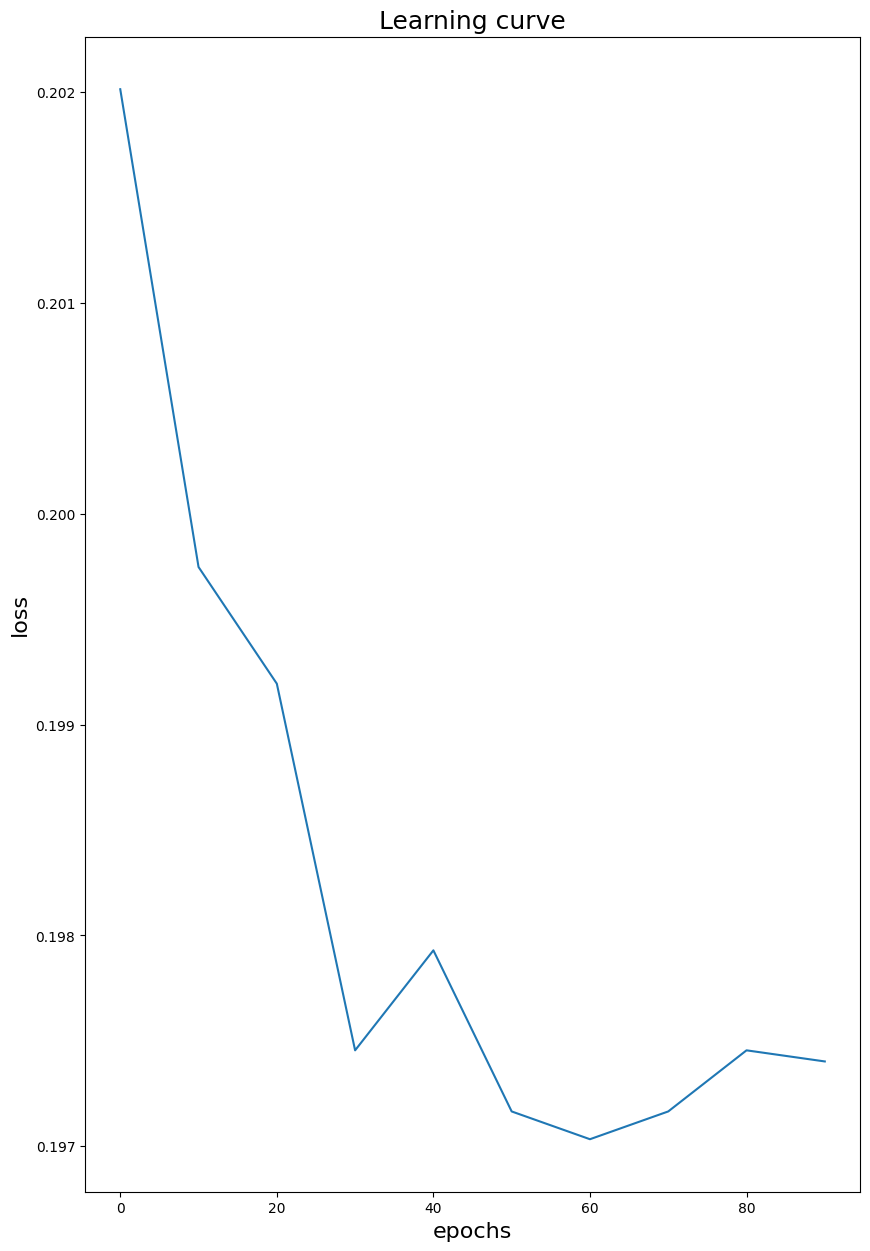

In [12]:
# model trained upon wholesome dataset

dataset.to_csv("./lab3-data-all.csv")

NN_model(
    "./lab3-data-all.csv",
    "REPEAT",
    [9],
    normalize=True,
    n_folds=10,
    epoch=100,
    eta=0.2,
    model_path="./NN_model.dat",
    crossValid=False
)

### 模型对比

`模型二`的训练过程中的损失函数如上图所示，可以看出，在训练迭代步数达到`60`时接近收敛，并且`loss`维持在`0.2`左右，无法再有效提高泛化性。随着迭代步数的增加，`loss`有上升趋势，说明出现了一定的过拟合现象。

`模型二`的准确率为`0.800`，和`模型一`一致，等于数据集中两个标签的统计量分布；`模型二`的`F1-Macro`达到了`0.5889`，高于随机森林模型；`AUC`为`0.5788`，高于随机森林模型。

从各项指标上可以看出，`模型二`的预测泛化性要比`模型一`稍微高一些，更能完成预测任务，但是训练时间长，且训练过程不可控。`模型一`的结构简单，单纯考察准确度则更高，且模型的中间过程有直观的解释，但是由于数据集中样本分布的天然偏差，实际上预测效果不好。

# 实验总结

与`REPEAT`字段存在关联性的特征：
- 父母中最高受教育程度`HISCED`;
- 家庭经济、社会、文化综合指数`ESCS`;
- 学生的移民身份`IMMIG`；
- 转校次数和累计转校次数`CHANGE`;
- 学生是否被欺凌(WLE)`BEINGBULLIED`;
- 学生在学业上花费的时间`TMINS`;
- 学校歧视氛围`DISCRIM`;

其中强相关的字段为`IMMIG,BEINGBULLIED`，在分类任务中发挥重要作用。通过神经网络模型，可以在选定的特征集合上达到预测指标`F1-score=0.58`的成绩。

我们对结论进行如下的解释：
- 一个家庭是否是移民家庭会导致孩子进行复读。这可能因为语言的原因，学生需要在语言学校预先学习半学期甚至更长；
- 学生是否遭到校园欺凌会导致学生进行复读。这可能因为学生由于心里原因抵触学校，因此进行休学或者转校，进而导致复读；
- 学生是否转校频繁会导致复读。这可能因为学生在转校过程中的课程进度存在差异，需要留级复读；

其余未考虑到，或者有讨论但没有加入到数据集中的特征：
- 学生的健康状态，例如是否有天生性疾病或者心里问题；
- 学费，例如是否家庭无法支付学费而导致学生转学，进而导致复读；

对于特征的筛选而言：
- 我们可以通过统计量的分布情况来预设一组和目标特征相关的特征集合；
- 对于不同类型的特征，可以使用不同的正则化的手法，例如`one-hot-code`，或者将连续变量划分为区间转为离散变量；
- 对于同类型，不同取值范围的特征，应使用一定的映射将其取值范围化为一致，或者相近的，避免因为绝对值而影响后续模型的权重分配；

对于模型而言：
- 由于数据集中`REPEAT`的取值的分布不均的问题，`准确度ACC`这一指标不能很好的反应模型的性能，我们需要综合考察模型对于每一种取值的预测能力，因此我们引入了类似于`F1-score Maroc`的指标等。
- 我们还需要交叉验证来规避掉数据集划分造成的偶然性，提高对模型性能考察的准确性。

# 附录

[Neuro Network](./neuro_network/neuro_network.py)

[NN algorithm](./neuro_network/src/NN.py)

[preprocess csv file](./neuro_network/src/utils.py)

[plot and read](./neuro_network/src/misc.py)

[Neuro Network model(.dat)](./NN_model.dat)

# 参考资料

深度学习参数调整之一：学习率调整-知乎[*1]

Machine Learning for Beginners: An Introduction to Neural Networks- Blog[*2]

深度学习调参有哪些技巧-知乎[*3]

[*1]:(https://zhuanlan.zhihu.com/p/359731367)
[*2]:(https://victorzhou.com/blog/intro-to-neural-networks/)
[*3]:(https://www.zhihu.com/question/25097993/answer/2717281021)